In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def feature_pareto(k: float, q: float, D: np.ndarray) -> np.ndarray:
    """
    Calculate the distribution of features larger than D based on the Pareto principle.
    
    n(>D) = k * D^(-q)
    """
    return k * D**(-q)

def shaded_area(k: float, q: float, D: np.ndarray, theta: np.ndarray):
    D = D.reshape(-1, 1)  # Ensure D is a column vector
    theta = theta.reshape(1, -1)  # Ensure theta is a row vector
    density = feature_pareto(k, q, D)
    average_distance = np.sqrt(1 / (np.pi * density + 1e-10))

    return D * D * np.tan(theta), average_distance, density


In [4]:
k = 5.0e-3
q = 3.0
D = np.linspace(1e0, 1e1, 20)
theta = np.linspace(30, 70, 90) * np.pi / 180

D_shaded, average_distance, density = shaded_area(k, q, D, theta)

# Analysis

To begin, the core assumption here is that the density of features on a scale relevant to the rover is power law-distributed as follows:

$$n(>D) = kD^{-q}$$

$k$ and $q$ are site-dependent, but generally take values on the order of $10^{-3} \text{ m}^{-2 + q} $ and $1.0$. For our exploration here, we use $k = 5.0 \times 10^{-3} \text{ m}^{-5} $ and $q=3.0$

The proportion that is shaded (subject to the precise distribution of craters and boulders in the region) can therefore be calculated as the product of the areal density of the features and the size of their shadow. The distance of the Sun from the moon allows us to model it as infinitely far; the only distortion is therefore in the direction of the light.

The area of the shade cast by objects of size $D$ is given by $D^2\tan\theta$.

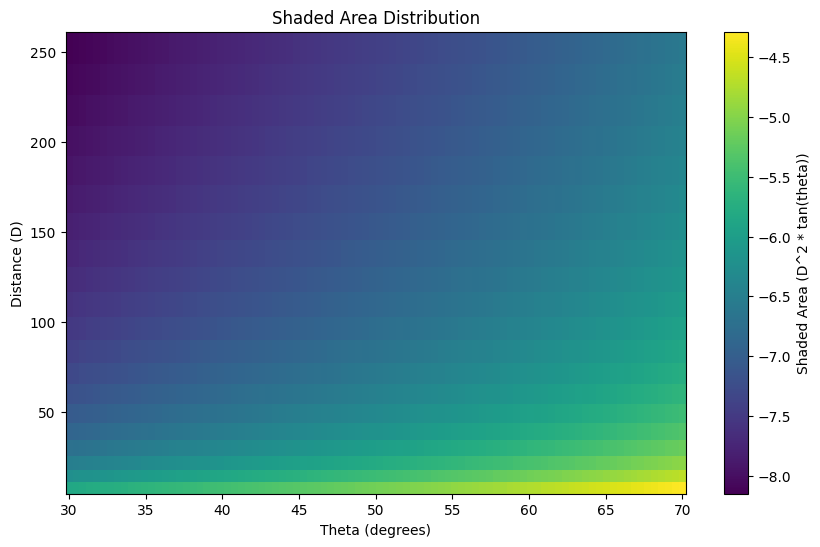

In [5]:
# Plotting the shaded area
plt.figure(figsize=(10, 6))
plt.pcolormesh(theta * 180 / np.pi, average_distance, np.log(D_shaded * density), shading='auto', cmap='viridis')
plt.colorbar(label='Shaded Area (D^2 * tan(theta))')
plt.xlabel('Theta (degrees)')
plt.ylabel('Distance (D)')
plt.title('Shaded Area Distribution')
plt.show()

We can see that 

In [9]:
k = 5.0e-3
q = 3.0
D = np.linspace(1e0, 1e1, 20)
theta = np.linspace(30, 70, 10) * np.pi / 180

D = D.reshape(-1, 1)  # Ensure D is a column vector
theta = theta.reshape(1, -1)  # Ensure theta is a row vector

shaded_area_per_feature = D * D * np.tan(theta)
average_distance_per_feature = np.sqrt(1 / (np.pi * feature_pareto(k, q, D) + 1e-10))

In [11]:
shaded_area_per_feature.shape

(20, 10)